# Cassava Leaf Disease Classification - fastai

In this notebook, we are trying to identify a  common leaf disease of cassava crops using data science and machine learning. We prefer to develop an automated pipeline based on mobile-quality images of the cassava crops to help the farmers easily to inspect and diagnise the plants.



## Lets take a look on our data

We'll start with setting up our envioronment by installing the required modules.


In [ ]:
!pip install ../input/pytorch-image-models/timm-0.3.4-py3-none-any.whl

Processing /kaggle/input/pytorch-image-models/timm-0.3.4-py3-none-any.whl


In [ ]:
import numpy as np
import os
import pandas as pd
from fastai.vision.all import *
import albumentations

let's set a random seed:

In [ ]:
set_seed(999,reproducible=True)

Done! now we'll have a look into the dataset

In [ ]:
dataset_path = Path('../input/cassava-leaf-disease-classification')
os.listdir(dataset_path)

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

okay..okay! so, we have  

1.   a 'train.csv' file with train image names and labels
2.    a 'sample submission.csv' with test image names
3.   the 'train' and 'test' image folder.
4.   a 'label num to disease map.json file to map the disease name with the image id.

(also we the train and test images in tfrecords format for quick loading of images, especailly for Tensorflow and TPU's. Dont worry! we wont be using that for now.)



Let's check what's inside the train.csv file :

In [ ]:
train_df = pd.read_csv(dataset_path/'train.csv')

In [ ]:
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


Good, now we are clear on how the image id is mapped to the corresponding label.


But! before we move any futher let's do some quick processing of the image filenames to make it easier to access: 

In [ ]:
train_df['path'] = train_df['image_id'].map(lambda x:dataset_path/'train_images'/x)
train_df = train_df.drop(columns=['image_id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head(10)

,label,path
0,3,../input/cassava-leaf-disease-classification/train_images/179052943.jpg
1,3,../input/cassava-leaf-disease-classification/train_images/1393343720.jpg
2,3,../input/cassava-leaf-disease-classification/train_images/3306053383.jpg
3,2,../input/cassava-leaf-disease-classification/train_images/51748275.jpg
4,2,../input/cassava-leaf-disease-classification/train_images/2896377982.jpg
5,2,../input/cassava-leaf-disease-classification/train_images/397242175.jpg
6,3,../input/cassava-leaf-disease-classification/train_images/3643428044.jpg
7,3,../input/cassava-leaf-disease-classification/train_images/3504544363.jpg
8,3,../input/cassava-leaf-disease-classification/train_images/2922394453.jpg
9,3,../input/cassava-leaf-disease-classification/train_images/587043810.jpg


That should do! Now let's check how many images are available in the training dataset :

In [ ]:
len_df = len(train_df)
print(f"There are {len_df} images")


There are 21397 images


Nice! we have more than 20,000 images. This is enough for us to develop a highly-predictive and generalizable model.


Ahh..Enough of blunt texts, Let's visualise the distribution of the available classes :

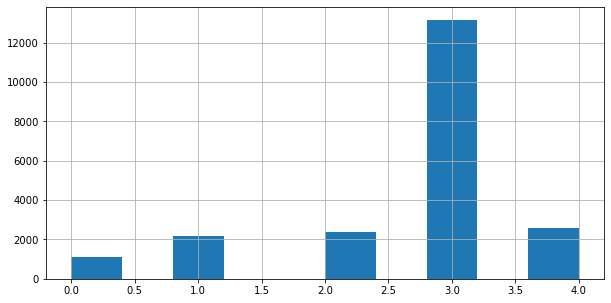

In [ ]:
train_df['label'].hist(figsize = (10, 5))


Label 3 is the most common label on our dateset out of four diseases and a healthy label. Let's address this imbalance in a future notebook.

Now, Let's check an example image to see what it looks like :

In [ ]:
from PIL import Image

img = Image.open(train_df['path'][1])
width, height = img.size
print(width,height) 

800 600


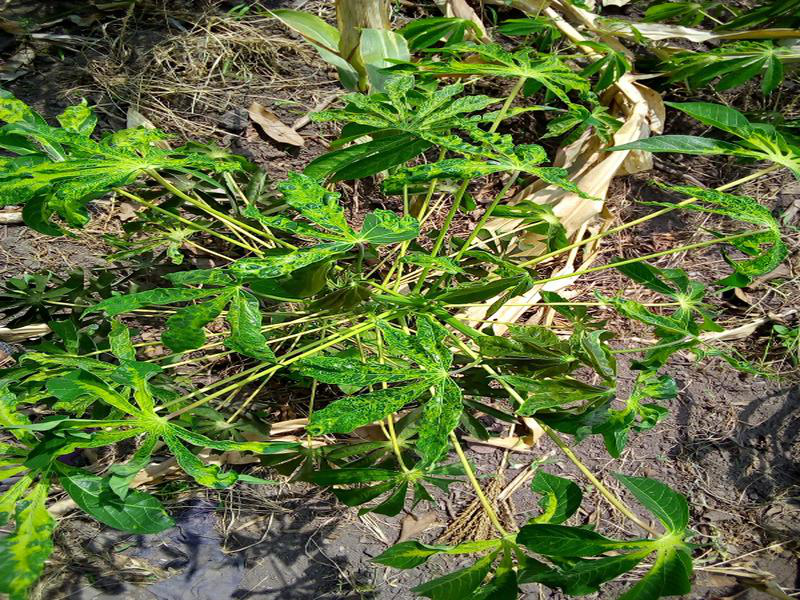

In [ ]:
img

I hope that's enough for our exploratory data analysis part. Let's jump into the main part!

#Data Loading...

First things first! Let's define item and batch transforms. These transforms are the albumetations transforms applied in fastai with a batch size of 32. Thanks to [@muellerzr](https://www.kaggle.com/muellerzr) for helping us with some code (see [here](https://www.kaggle.com/muellerzr/recreating-abhishek-s-tez-with-fastai) for more details.)

In [ ]:
class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [ ]:
def get_train_aug(sz): return albumentations.Compose([
            albumentations.RandomResizedCrop(sz,sz),
            albumentations.Transpose(p=0.5),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
            albumentations.CoarseDropout(p=0.5),
            albumentations.Cutout(p=0.5)
])

def get_valid_aug(sz): return albumentations.Compose([
    albumentations.CenterCrop(sz,sz, p=1.),
    albumentations.Resize(sz,sz)
], p=1.)

fastai provides various ways of doing custom dataloading, traditional iamge classification problems work well with high-level data API. Let's pass all the required info to create an 'DataLoaders' object.

In [ ]:
def get_dls(sz,bs):
    item_tfms = AlbumentationsTransform(get_train_aug(sz), get_valid_aug(sz))
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]
    dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                                   valid_pct=0.2, #80-20 train-validation random split
                                   seed=999, #seed
                                   label_col=0, #label is in the first column of the DataFrame
                                   fn_col=1, #filename/path is in the second column of the DataFrame
                                   bs=bs, #pass in batch size
                                   item_tfms=item_tfms, #pass in item_tfms
                                   batch_tfms=batch_tfms) #pass in batch_tfms
    return dls

In [ ]:
dls = get_dls(456,16)

Did we create a successful DataLoader? 

Let's verify it using the *show_batch* command, which shows a subset of the batch :

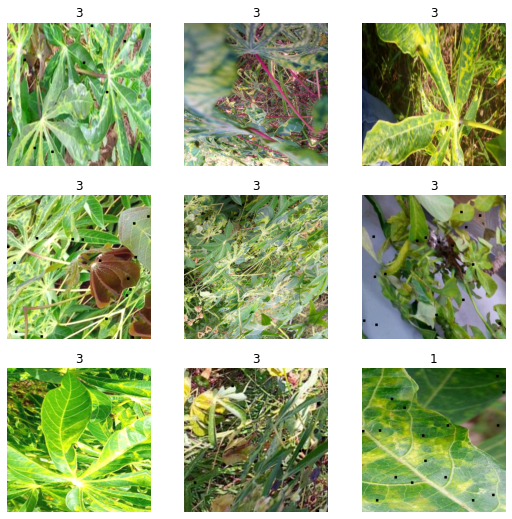

In [ ]:
dls.show_batch()

#Model Training

Let's train a simple EfficientNet-B5 model. We'll load the pretrained weights from [timm](https://github.com/rwightman/pytorch-image-models/tree/master/timm) package by Ross Wightman to define the model.

In [ ]:
# Making pretrained weights work without needing to find the default filename
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
        os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/timmefficientnet/tf_efficientnet_b5_ns-6f26d0cf.pth' '/root/.cache/torch/hub/checkpoints/tf_efficientnet_b5_ns-6f26d0cf.pth'

The above code will allow timm to find the file.

In fastai, the trainer class is the Learner, which takes in the data, model, optimizer, loss function, etc. and allows you to train models, make predictions, etc.

Most commonly we use *cnn_learner* function for training when using common models like ResNets,  which creates a Learner object that allows us to train a provided model with the given dataloaders. But *cnn_learner* is not supported for *timm* . @muellerzr has given us some [simple functions](https://walkwithfastai.com/vision.external.timm) to make it easy to create Learner objects for timm models.

In [ ]:
from timm import create_model
from fastai.vision.learner import _update_first_layer

def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")
        
def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=True, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from the `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model

In [ ]:
def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

Let's now create our *Learner* object. We will also use common state-of-the-art training techniques like label smoothing and Ranger optimizer, which are provided in fastai. We can also use mixed precision very easily:

In [ ]:
learn = timm_learner(dls, 
                    'tf_efficientnet_b5_ns',
                     opt_func=ranger,
                     loss_func=LabelSmoothingCrossEntropy(),
                     cbs=[GradientAccumulation(n_acc=32)],
                     metrics = [accuracy]).to_native_fp16()

We are now provided with a Learner object which has a frozen model (only the weights of the head of the model can be updated). We'll use fastai's learning rate finder to find the most optimal learning rate to train our model.

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=1.0964781722577754e-06)

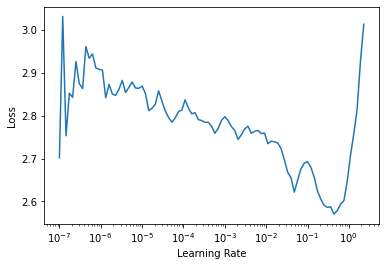

In [ ]:
learn.lr_find()

As shown above, the optimal learning rate for training the frozen model is where the loss is decreasing most rapidly: around ~1e-1. To be safe, we will use high weight decay to help prevent overfitting. We will also use another common state-of-the-art training technique: mixup.

Let's start training the model. Often, the best way to train a model is to train the frozen pretrained model for a single epoch then train the whole pretrained model for several epochs. The Ranger optimizer performs best with a *flat+cosine annealing* learning rate schedule. We will now train the frozen model for one epoch.

In [ ]:
learn.freeze()
learn.fit_flat_cos(1,1e-1, wd=0.1, cbs=[MixUp()])

epoch,train_loss,valid_loss,accuracy,time
0,1.001680,0.744433,0.831970,10:53


In [ ]:
learn.save('stage-1')

Path('models/stage-1.pth')

In [ ]:
learn = learn.load('stage-1')

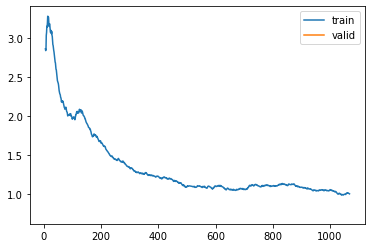

In [ ]:
learn.recorder.plot_loss()

Let's now unfreeze the model and find a good learning rate:

SuggestedLRs(lr_min=4.786300996784121e-05, lr_steep=9.12010818865383e-07)

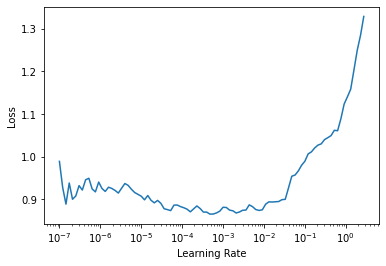

In [ ]:
learn.unfreeze()
learn.lr_find()

Let's train for 10 epochs with the unfrozen model.

In [ ]:
learn.unfreeze()
learn.fit_flat_cos(10, 1e-3,cbs=[MixUp(),SaveModelCallback()])

epoch,train_loss,valid_loss,accuracy,time
0,0.986037,0.698643,0.857443,15:22
1,0.927395,0.687141,0.858612,15:23
2,0.923212,0.680853,0.867960,15:23
3,0.913200,0.670045,0.873569,15:23
4,0.870620,0.668773,0.871933,15:24
5,0.879011,0.670111,0.874737,15:25
6,0.884507,0.668882,0.872400,15:26
7,0.874386,0.650237,0.876840,15:27
8,0.863822,0.643901,0.885487,15:25
9,0.869299,0.641689,0.887123,15:25


Better model found at epoch 0 with valid_loss value: 0.6986430883407593.
Better model found at epoch 1 with valid_loss value: 0.6871410608291626.
Better model found at epoch 2 with valid_loss value: 0.6808528304100037.
Better model found at epoch 3 with valid_loss value: 0.670045018196106.
Better model found at epoch 4 with valid_loss value: 0.6687728762626648.
Better model found at epoch 7 with valid_loss value: 0.6502372622489929.
Better model found at epoch 8 with valid_loss value: 0.6439007520675659.
Better model found at epoch 9 with valid_loss value: 0.6416889429092407.


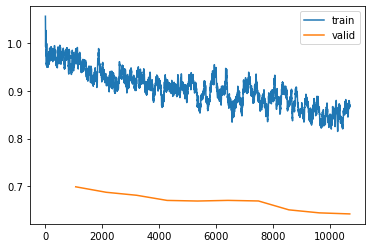

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn = learn.to_native_fp32()

In [ ]:
learn.save('stage-2')

Path('models/stage-2.pth')

We plotted the loss, put the model back to fp32, and now we can export the model if we want to use later (i.e. for an inference kernel):

In [ ]:
learn.export()

# Inference

It's very simple to perform inference with fastai. The dls.test_dl function allows you to create test dataloader using the same pipeline defined earlier.

In [ ]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
sample_df.head()

,image_id,label
0,2216849948.jpg,4


In [ ]:
_sample_df = sample_df.copy()
_sample_df['path'] = _sample_df['image_id'].map(lambda x:dataset_path/'test_images'/x)
_sample_df = _sample_df.drop(columns=['image_id'])
test_dl = dls.test_dl(_sample_df)

Let's confirm that the test_dl is correct:

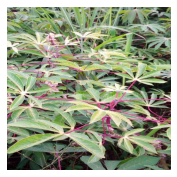

In [ ]:
test_dl.show_batch()

Now let's pass the dataloader to the model and get predictions. We will use a common inference technique known as test-time augmentation (average predictions when passing in various augmented versions of the test image). This is also implemented in fastai. Let's do 8x TTA(Test-Time Augumentation):

In [ ]:
preds, _ = learn.tta(dl=test_dl, n=15, beta=0)

In [ ]:
sample_df['label'] = preds.argmax(dim=-1).numpy()

In [ ]:
sample_df.to_csv('submission.csv',index=False)

Voila..! We've done our job! 

Hope I've made you clear with this notebook. If you have any questions or suggestions, please leave a comment!